# SAN-VQA Demonstration

---

* Steps
  * Convert the image to features **v**
  *  Convert the question to a torch vector of longs
  *  Pass both into the the VQA model
  *  Interpret the softmax-y answer vectors

* Resources ~ 
  * https://github.com/Cyanogenoid/pytorch-vqa
  * https://github.com/Cyanogenoid/vqa-counting/tree/master/vqa-v2

---

### Table of contents ~
#### 1. Creating the environment
#### 2. Preprocessing the data
#### 3. Training the model
#### 4. Testing the model


## Creating the environment
---

#### Importing and preparing data

In [ ]:
# Upgrade pillow to latest version to resolve an attribute issue when importing model
! pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os, sys
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
try:
  path = "/content/data"
  os.mkdir(path)
  path = "/content/data/vqa"
  os.mkdir(path)
  path = "/content/data/mscoco"
  os.mkdir(path)
  path = "/content/data/mscoco/val2015"
  os.mkdir(path)
  path = "/content/data/mscoco/test2015"
  os.mkdir(path)
  path = "/content/data/mscoco/train2015"
  os.mkdir(path)
except:
  print("Folder already exists...")
finally:
  print("The folders are now ready!")

Folder already exists...
The folders are now ready!


In [ ]:
# Importing question-answer pairs
!unzip '/content/drive/MyDrive/VQA Abstract/vqa/Questions_Val_abstract_v002.zip' -d '/content/data/vqa'
!unzip '/content/drive/MyDrive/VQA Abstract/vqa/Questions_Test_abstract_v002.zip' -d '/content/data/vqa'
!unzip '/content/drive/MyDrive/VQA Abstract/vqa/Annotations_Val_abstract_v002.zip' -d '/content/data/vqa'
!unzip '/content/drive/MyDrive/VQA Abstract/vqa/Questions_Train_abstract_v002.zip' -d '/content/data/vqa'
!unzip '/content/drive/MyDrive/VQA Abstract/vqa/Annotations_Train_abstract_v002.zip' -d '/content/data/vqa'

# Importing images
!unzip '/content/drive/MyDrive/VQA Abstract/mscoco/scene_img_abstract_v002_val2015.zip' -d '/content/data/mscoco/val2015'
!unzip '/content/drive/MyDrive/VQA Abstract/mscoco/scene_img_abstract_v002_test2015.zip' -d '/content/data/mscoco/test2015/'
!unzip '/content/drive/MyDrive/VQA Abstract/mscoco/scene_img_abstract_v002_train2015.zip' -d '/content/data/mscoco/train2015'

#### Importing the prebuilt VQA model

In [ ]:
if not os.path.isfile('./pytorch-vqa/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-vqa.git
sys.path.append(os.path.realpath('./pytorch-vqa'))

Cloning into 'pytorch-vqa'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 51 (delta 2), reused 6 (delta 2), pack-reused 40
Unpacking objects: 100% (51/51), done.


#### Acelerating using CUDA

In [ ]:
try: 
    import torch
except:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'
    !pip install -q \
      http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl \
      torchvision

In [ ]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Preprocessing the data

---

> Constructing vocabulary

In [ ]:
!python /content/pytorch-vqa/preprocess-vocab.py

> The following edits have been done:
* Path names are added in config.py
* Dataset name has been set to "abstract_v002" in config.py
* In the utils.py file, the function 'path_for' has been changed, and the split for train and val are set to "train2015" and "val2015" respectively

In [ ]:
import json
# Opening JSON file
with open('/content/data/vocab.json', 'r') as file:
  
    # Reading from json file
    json_object = json.load(file)
  
print(json_object)
print(len(json_object))

{'question': {'the': 1, 'is': 2, 'what': 3, 'are': 4, 'on': 5, 'how': 6, 'many': 7, 'in': 8, 'color': 9, 'a': 10, 'there': 11, 'of': 12, 'to': 13, 'man': 14, 'woman': 15, 'dog': 16, 'girl': 17, 'where': 18, 'boy': 19, 'does': 20, 'doing': 21, 'sitting': 22, 'this': 23, 'cat': 24, 'people': 25, 'with': 26, 'they': 27, 'have': 28, 'table': 29, 'picture': 30, 'playing': 31, 'it': 32, 'do': 33, 'couch': 34, 'lady': 35, 'tree': 36, 'holding': 37, 'baby': 38, 'at': 39, 'or': 40, 'who': 41, 'pond': 42, 'room': 43, 'she': 44, 'animal': 45, 'rug': 46, 'her': 47, 'for': 48, 'little': 49, 'old': 50, 'why': 51, 'sun': 52, 'kind': 53, 'will': 54, 'wall': 55, 'fire': 56, 'ball': 57, 'that': 58, 'you': 59, 'curtains': 60, 'see': 61, 'shirt': 62, 'blanket': 63, 'trees': 64, 'same': 65, 'animals': 66, 'his': 67, 'floor': 68, 'and': 69, 'windows': 70, 'be': 71, 'two': 72, 'sky': 73, 'he': 74, 'fireplace': 75, 'tv': 76, 'any': 77, 'going': 78, 'chair': 79, 'can': 80, 'bench': 81, 'did': 82, 'food': 83, '

> Constructing image features

In [ ]:
if not os.path.isfile('./pytorch-resnet/README.md'):
    !git clone https://github.com/Cyanogenoid/pytorch-resnet.git
sys.path.append(os.path.realpath('./pytorch-resnet'))

Cloning into 'pytorch-resnet'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (28/28), done.


In [ ]:
!python /content/pytorch-vqa/preprocess-images.py

found 20000 images in /content/data/mscoco/train2015
found 10000 images in /content/data/mscoco/val2015
  0% 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
  0% 1/938 [00:01<18:23,  1.18s/it]tensor([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])
tensor([64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95])
  0% 3/938 [00:01<05:58,  2.61it/s]tensor([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105,

> The following edits have been done ~
* In the preprocess-images.py 'async' in line 63 is changed to 'non-blocking'
* The file 'resnet.py' from 'pytorch-resnet' is moved to the folder 'resnet' under 'pytorch-vqa'
* In the file data.py, in line 221, '.jpg' was replaced with '.png'
* 'data_workers' changed to 2 in config.py file
* In config file, 'preprocess_batch_size' is set to 32 and 'image_size' is set to 128

## Training the model

---

In [ ]:
!python /content/pytorch-vqa/train.py

will save to /content/pytorch-vqa/logs/2022-06-18_13:27:37.pth
/content/pytorch-vqa/model.py:86: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.embedding.weight)
/content/pytorch-vqa/model.py:44: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(m.weight)
train E000:   0% 0/937 [00:00<?, ?it/s]/content/pytorch-vqa/train.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  nll = -log_softmax(out)
train E000: 100% 937/937 [00:39<00:00, 23.94it/s, acc=0.4887, loss=2.3794]
val E000:   0% 0/469 [00:00<?, ?it/s]/content/pytorch-vqa/train.py:50: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  v = Variable(v.cuda(non_blocking=True), **var_params)
/content/pytorch-vqa/train.py:51: UserWarning: volatile was removed and now has no effect.

> The following edits have been done ~
* In the train.py 'async' in lines 50-53 is changed to 'non-blocking'
* In the train.py file, in line 76, data[0] was changed to data as it is a 0-dim tensor

#### Training measure

In [ ]:
!python /content/pytorch-vqa/view-log.py '/content/drive/MyDrive/VQA Abstract/2022-06-18_13_27_37.pth'

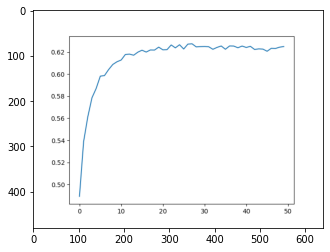

In [ ]:
from PIL import Image
img = Image.open('/content/drive/MyDrive/VQA Abstract/val_acc.png').convert('RGB')
plt.imshow(img)

#### Loading the weights obtained from training

In [ ]:
saved_state = torch.load('/content/pytorch-vqa/logs/2022-06-18_13:27:37.pth', map_location=device)
tokens = len(saved_state['vocab']['question']) + 1
saved_state.keys()

dict_keys(['name', 'tracker', 'config', 'weights', 'eval', 'vocab'])

In [ ]:
# Loading the model with weights

import importlib.util

MODULE_PATH = "/content/pytorch-vqa/model.py"
MODULE_NAME = "model"

spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
model = importlib.util.module_from_spec(spec)
spec.loader.exec_module(model)

vqa_net = torch.nn.DataParallel(model.Net(tokens))
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()

DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(4802, 300, padding_idx=0)
      (drop): Dropout(p=0.5, inplace=False)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5, inplace=False)
      (relu): ReLU(inplace=True)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5, inplace=False)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5, inplace=False)
      (lin2): Linear(in_features=1024, out_features=3000, bias=True)
    )
  )
)

#### Looking at the vocab

In [ ]:
vocab = saved_state['vocab']
vocab.keys()  # dict_keys(['question', 'answer'])
list(vocab['question'].items())

[('the', 1),
 ('is', 2),
 ('what', 3),
 ('are', 4),
 ('on', 5),
 ('how', 6),
 ('many', 7),
 ('in', 8),
 ('color', 9),
 ('a', 10),
 ('there', 11),
 ('of', 12),
 ('to', 13),
 ('man', 14),
 ('woman', 15),
 ('dog', 16),
 ('girl', 17),
 ('where', 18),
 ('boy', 19),
 ('does', 20),
 ('doing', 21),
 ('sitting', 22),
 ('this', 23),
 ('cat', 24),
 ('people', 25),
 ('with', 26),
 ('they', 27),
 ('have', 28),
 ('table', 29),
 ('picture', 30),
 ('playing', 31),
 ('it', 32),
 ('do', 33),
 ('couch', 34),
 ('lady', 35),
 ('tree', 36),
 ('holding', 37),
 ('baby', 38),
 ('at', 39),
 ('or', 40),
 ('who', 41),
 ('pond', 42),
 ('room', 43),
 ('she', 44),
 ('animal', 45),
 ('rug', 46),
 ('her', 47),
 ('for', 48),
 ('little', 49),
 ('old', 50),
 ('why', 51),
 ('sun', 52),
 ('kind', 53),
 ('will', 54),
 ('wall', 55),
 ('fire', 56),
 ('ball', 57),
 ('that', 58),
 ('you', 59),
 ('curtains', 60),
 ('see', 61),
 ('shirt', 62),
 ('blanket', 63),
 ('trees', 64),
 ('same', 65),
 ('animals', 66),
 ('his', 67),
 ('flo

## Testing the model
---

In [ ]:
import importlib.util

MODULE_PATH = "/content/pytorch-vqa/resnet/resnet.py"
MODULE_NAME = "resnet"

spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
resnet = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet)

import torchvision.transforms as transforms
from PIL import Image

def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Resize(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super(ResNetLayer4, self).__init__()
        self.model = resnet.resnet152(pretrained=True)
        
        # from  visual_qa_analysis/config.py
        image_size = 128  # scale shorter end of image to this size and centre crop
        #output_size = image_size // 32  # size of the feature maps after processing through a network
        output_features = 2048  # number of feature maps thereof
        central_fraction = 0.875 # only take this much of the centre when scaling and centre cropping

        self.transform = get_transform(image_size, central_fraction)

        def save_output(module, input, output):
            self.buffer = output
        self.model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        self.model(x)
        return self.buffer
    
    def image_to_features(self, img_file):
        img = Image.open(img_file).convert('RGB')
        img_transformed = self.transform(img)
        #print(img_transformed.size())
        img_batch = img_transformed.unsqueeze(0).to(device)
        return self.forward(img_batch) 
    
resnet_layer4 = ResNetLayer4().to(device)  # Downloads 241Mb model when first run

In [ ]:
# Sample images : 
image_path, image_files = '/content/data/mscoco/test2015/abstract_v002_test2015_0000000', []
os.makedirs('/content/data/mscoco/test2015', exist_ok=True)
for i in range(30000, 30005): # Testing on 5 images as question-answer pair for test set is not available in VQA dataset
    image_file=image_path + str(i) + '.png'
    image_files.append(image_file)
image_files

['/content/data/mscoco/test2015/abstract_v002_test2015_000000030000.png',
 '/content/data/mscoco/test2015/abstract_v002_test2015_000000030001.png',
 '/content/data/mscoco/test2015/abstract_v002_test2015_000000030002.png',
 '/content/data/mscoco/test2015/abstract_v002_test2015_000000030003.png',
 '/content/data/mscoco/test2015/abstract_v002_test2015_000000030004.png']

In [ ]:
v = []
for i in image_files:
  v.append(resnet_layer4.image_to_features(i))
len(v)

5

#### Testing the first image

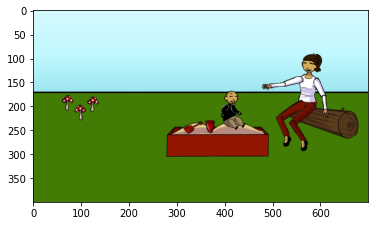

In [ ]:
image_idx = 1
image_filename = image_files[image_idx]

img = Image.open(image_filename).convert('RGB')
plt.imshow(img)

In [ ]:
v0 = v[1]

#### Encoding questions

In [ ]:
qtoken_to_index = vocab['question']
QUESTION_LENGTH_MAX = 30 # say...
    
def encode_question(question_str):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question_str.lower().split(' ')
    #vec = torch.zeros(QUESTION_LENGTH_MAX).long()
    vec = torch.zeros(len(question_arr)).long()  
    for i, token in enumerate(question_arr):
        vec[i] = qtoken_to_index.get(token, 0)
    return vec.to(device), torch.tensor( len(question_arr) ).to(device)

In [ ]:
q, q_len = encode_question("is there green in the picture")
q, q_len

(tensor([  2,  11, 265,   8,   1,  30], device='cuda:0'),
 tensor(6, device='cuda:0'))

In [ ]:
ans = vqa_net(v0, q.unsqueeze(0), q_len.unsqueeze(0))
ans.data.cpu()[0:10]

tensor([[ -4.7642,  -8.1770, -10.4731,  ..., -38.6509, -42.3043, -33.5807]])

In [ ]:
answer_words = ['UNDEF'] * len(vocab['answer'])
for w,idx in vocab['answer'].items():
    answer_words[idx]=w
len(answer_words), answer_words[:10]  # 3000, ['yes', 'no', '2', '1', 'white', '3', 'red', 'blue', '4', 'green']

(3000, ['yes', 'no', '2', '1', 'red', '3', 'white', '4', 'blue', 'yellow'])

In [ ]:
_, answer_idx = ans.data.cpu().max(dim=1)
answer_words[ answer_idx ]

'yes'

In [ ]:
#### Trying combinations of words

In [ ]:
def vqa_single_softmax(im_features, q_str):
    q, q_len = encode_question(q_str)
    ans = vqa_net(im_features, q.unsqueeze(0), q_len.unsqueeze(0))
    return ans.data.cpu()

In [ ]:
def leave_out_combos(image_filename, question_base):
    plt.imshow(Image.open(image_filename).convert('RGB')); plt.show()    
    image_features = resnet_layer4.image_to_features(image_filename)
    question_arr = question_base.lower().split(' ')
    for i in range(2 ** len(question_arr)):
        q_arr = [question_arr[j] for j in range(len(question_arr)) if (i & (2**j))==0 ]
        question_str = ' '.join( q_arr )
        _, answer_idx = vqa_single_softmax(image_features, question_str).max(dim=1)
        print((answer_words[ answer_idx ]+' '*8)[:8]+" <- "+question_str)

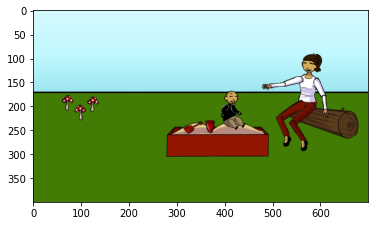

yes      <- is there green in the picture
yes      <- there green in the picture
yes      <- is green in the picture
5        <- green in the picture
yes      <- is there in the picture
yes      <- there in the picture
yes      <- is in the picture
yes      <- in the picture
yes      <- is there green the picture
yes      <- there green the picture
yes      <- is green the picture
watermel <- green the picture
yes      <- is there the picture
yes      <- there the picture
yes      <- is the picture
yes      <- the picture
yes      <- is there green in picture
yes      <- there green in picture
yes      <- is green in picture
5        <- green in picture
yes      <- is there in picture
yes      <- there in picture
yes      <- is in picture
no       <- in picture
yes      <- is there green picture
yes      <- there green picture
yes      <- is green picture
yes      <- green picture
yes      <- is there picture
yes      <- there picture
yes      <- is picture
yes      <- picture
yes     

In [ ]:
image_idx = 1

leave_out_combos(image_files[image_idx], "is there green in the picture")

#### Trying various questions

In [ ]:
def vqa(image_filename, question_arr):
    plt.imshow(Image.open(image_filename).convert('RGB')); plt.show()    
    image_features = resnet_layer4.image_to_features(image_filename)
    for question_str in question_arr:
        _, answer_idx = vqa_single_softmax(image_features, question_str).max(dim=1)
        #print(question_str+" -> "+answer_words[ answer_idx ])
        print((answer_words[ answer_idx ]+' '*8)[:8]+" <- "+question_str)

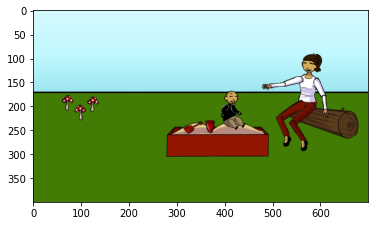

yes      <- is there green in the picture
yes      <- is there a log in the picture
yes      <- is there a woman in the picture
yes      <- is there a baby in the picture
yes      <- are there mushrooms in the picture


In [ ]:
image_idx = 1 

vqa(image_files[image_idx], [
    "is there green in the picture",
    "is there a log in the picture",
    "is there a woman in the picture",
    "is there a baby in the picture",
    "are there mushrooms in the picture"
])

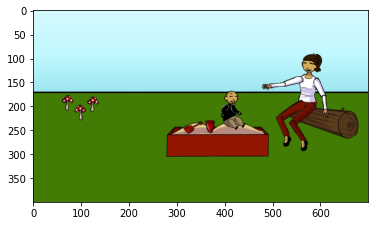

no       <- is there a man in the picture
no       <- is there a mountain in the picture
no       <- is there a car in the picture


In [ ]:
vqa(image_files[image_idx], [
    "is there a man in the picture",
    "is there a mountain in the picture",
    "is there a car in the picture",
])